# Veremos alguns conceitos relevantes sobre treinamento:

* Sementes
* Learning rate scheduler
* Aumento de dados
* ?

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

### Sementes

In [2]:
def seed_all(seed):
    "Seed Pytorch, numpy and Python."
    torch.manual_seed(seed)
    random.seed(seed) 
    np.random.seed(seed)

seed_all(0)

### Learning rate scheduler

In [3]:
from torch.optim import lr_scheduler

num_epochs = 100
lr = 0.1

# Dataset artificial para ilustração
ds = torch.rand(10,2)
# Parâmetro artificial para ilustração, normalmente seria todos os parâmetros de uma rede
p = torch.nn.Parameter(torch.rand(1))
# Otimizador
optim = torch.optim.SGD([p], lr=lr)
# Loop típico de treinamento
for epoch in range(num_epochs):
    for imgs, targets in ds:
        #Aplica o modelo no batch, calcula os gradientes
        #...
        # Atualiza os parâmetros: p -= lr*p.grad
        optim.step()

In [4]:
optim = torch.optim.SGD([p], lr=lr)
sched = lr_scheduler.PolynomialLR(optim, total_iters=num_epochs, power=1.)

for epoch in range(num_epochs):
    for imgs, targets in ds:
        #Aplica o modelo no batch, calcula os gradientes
        #...
        # Atualiza os parâmetros: p -= lr*p.grad
        optim.step()
    # Altera o valor de lr
    sched.step()

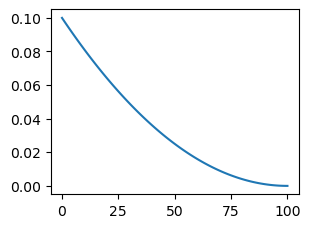

In [5]:
optim = torch.optim.SGD([p], lr=lr)
sched = lr_scheduler.PolynomialLR(optim, total_iters=num_epochs, power=2)

lrs = [sched.get_last_lr()]
for _ in range(num_epochs):
    optim.step()
    sched.step()
    lrs.append(sched.get_last_lr())

plt.plot(lrs)

### Aumento de dados

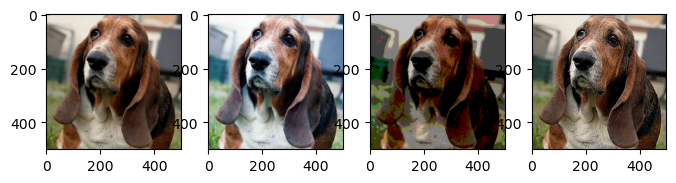

In [11]:
from PIL import Image
import torchvision.transforms.v2 as transf

def show_imgs(imgs):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(2*n,3))
    for img, ax in zip(imgs, axs):
        ax.imshow(img)

img = Image.open('../data/basset_hound_53.jpg')
# Equalização de histograma
img_eq = transf.RandomEqualize(p=1.)(img)
# Representação da imagem com menos bits
img_pos = transf.RandomPosterize(bits=2, p=1.)(img)
# Aumenta a nitidez da imagem (realça bordas)
img_sharp = transf.RandomAdjustSharpness(sharpness_factor=10, p=1.)(img)
show_imgs([img, img_eq, img_pos, img_sharp])

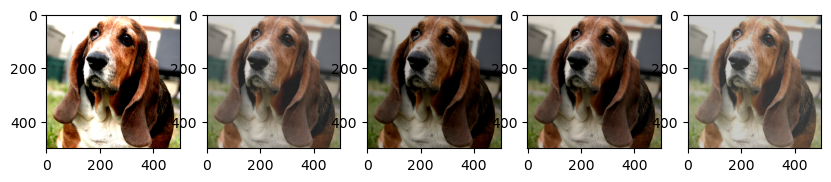

In [12]:
# saturação: quão "vivas" são as cores
# hue: colorização da imagem (esverdeada, avermelhada, etc)
cj = transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.01)
imgs = []
for _ in range(5):
    imgs.append(cj(img))
show_imgs(imgs)

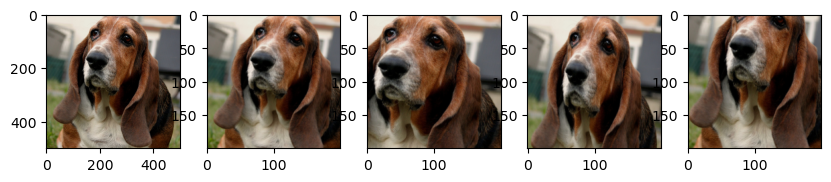

In [13]:
rescrop = transf.RandomResizedCrop(size=(200,200), scale=(0.5,1.), ratio=(0.7,1.3))
imgs = [img]
for _ in range(4):
    imgs.append(rescrop(img))
show_imgs(imgs)

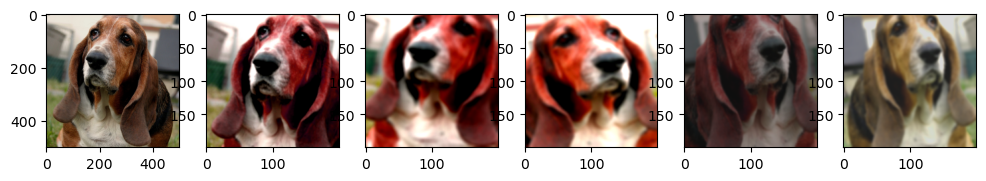

In [14]:
transform = transf.Compose([
    #transf.PILToTensor(),   # Recomendado por questão de eficiência
    transf.RandomResizedCrop(size=(200,200), scale=(0.5,1.), ratio=(0.7,1.3)),
    transf.RandomHorizontalFlip(),
    transf.GaussianBlur(kernel_size=7, sigma=(0.5, 3.)),
    transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transf.RandomEqualize(p=0.1),
    transf.RandomPosterize(bits=8, p=0.1),
    transf.RandomAdjustSharpness(sharpness_factor=5, p=0.1),
    #transf.ToDtype(torch.float32),
    #transf.Normalize(mean=(128, 132, 142), std=(23, 43, 34)), # Removido para facilitar visualização
])
imgs = [img]
for _ in range(5):
    imgs.append(transform(img))
show_imgs(imgs)

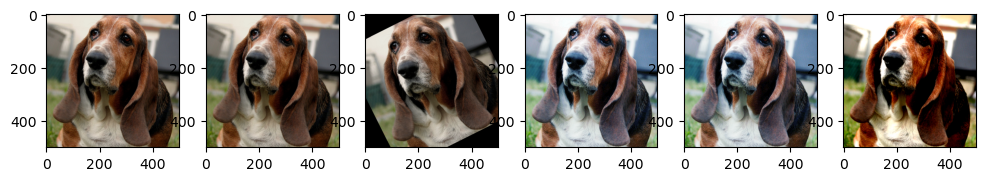

In [15]:
auto = transf.AutoAugment()
imgs = [img]
for _ in range(5):
    imgs.append(auto(img))
show_imgs(imgs)